In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
print(os.getcwd())
os.chdir('../../')
print(os.getcwd())

/home/tasnina/Projects/SynVerse/code/feature_extraction
/home/tasnina/Projects/SynVerse


In [5]:
dataset_dir = "datasets/"
processed_drug_feature_path = dataset_dir + 'processed/drug/'
drug_pair_score_file = dataset_dir+ 'drug-comb-db/' + 'drugcombs_scored.csv'

drugcombdb_drug_chem_smiles_maccskeys_info_file =  processed_drug_feature_path + 'drug_chem_smiles_maccskeys_info_file.tsv'
drugbank_drug_target_mapping_file = processed_drug_feature_path+ 'drug_target_map_drugbank.tsv'
TTD_drug_target_mapping_file= processed_drug_feature_path+'drug_target_map_TTD.tsv'

input_synergy_dir = "inputs/synergy/"
input_drug_dir = "inputs/drugs/"
TTD_drugbank_drug_target_map_file = input_drug_dir+'drug_target_map.tsv'
single_drug_training_maccskeys_target_feature_file_path = input_drug_dir + 'single_drugs_maccskeys_target_features.tsv'
single_drug_training_maccskeys_feature_file_path = input_drug_dir + 'single_drugs_maccskeys_features.tsv'
training_label_synergy_score_file_path =  input_synergy_dir + 'synergy_labels.tsv'




output_dir = "outputs/"

# Combine protein target data from TTD, Drugbank and MACCSKEYS data for drugs in drugcombdb

In [6]:
#combine drugbank and TTD drug-target information

drugbank_drug_target_df = pd.read_csv(drugbank_drug_target_mapping_file, sep='\t')
drugbank_drug_target_df['pubchem_cid'] = drugbank_drug_target_df['pubchem_cid'].astype(str)

TTD_drug_target_df = pd.read_csv(TTD_drug_target_mapping_file, sep='\t')
TTD_drug_target_df['pubchem_cid'] = TTD_drug_target_df['pubchem_cid'].astype(str)

drug_target_df = pd.concat([drugbank_drug_target_df, TTD_drug_target_df], axis= 0)


print('drugbank:', drugbank_drug_target_df.head())
print('TTD: ', TTD_drug_target_df.head())

os.makedirs(os.path.dirname(TTD_drugbank_drug_target_map_file), exist_ok=True)

df = drug_target_df[['pubchem_cid','uniprot_id']].drop_duplicates()
print(df.head())
df.to_csv(TTD_drugbank_drug_target_map_file, sep='\t')
#note: 1. a pubchem id can be mapped to multiple drug_name
#     2. a drug_name can be mapped to multiple pubchem_id
#     So many to many relationship



drugbank:   pubchem_cid    drug_name uniprot_id
0   101041682  Bivalirudin     P00734
1   101041682  Bivalirudin     P05164
2      657181   Leuprolide     P30968
3      657181   Leuprolide     P08684
4     5311128    Goserelin     P22888
TTD:    pubchem_cid                                         drug_name uniprot_id
0    23643731          8-O-(4-chlorobenzenesulfonyl)manzamine F     P49841
1    44341439               2-Hexyloxy-5-imidazol-1-yl-pyridine     P10635
2    44435223  Anthracen-10-yl(10H-phenothiazin-10-yl)methanone     P06276
3       73255                                        VOACANGINE     P22303
4         702                                           Ethanol     P14867
  pubchem_cid uniprot_id
0   101041682     P00734
1   101041682     P05164
2      657181     P30968
3      657181     P08684
4     5311128     P22888


In [7]:
#create the feature matrix containing all the targets for a drug as a 0-1 vector.
unique_proteins = drug_target_df['uniprot_id'].unique()
unique_proteins_in_Index_form = pd.Index(pd.Series(unique_proteins))
number_of_unique_proteins = len(unique_proteins)
unique_pubchem_ids = drug_target_df['pubchem_cid'].unique()

drug_targets ={ pubchem_id: np.zeros(number_of_unique_proteins, dtype=int) for pubchem_id in  unique_pubchem_ids}

for index,row in drug_target_df.iterrows():
    #find the index of the current target (i.e.present in the current row) in unique_proteins
    prot_position = unique_proteins_in_Index_form.get_loc(row['uniprot_id'])
    drug_targets[row['pubchem_cid']][prot_position] = 1
    
drug_target_df_feature_ready = pd.DataFrame.from_dict(drug_targets, orient='index', columns=unique_proteins)
drug_target_df_feature_ready = drug_target_df_feature_ready.reset_index().rename(columns={'index':'pubchem_cid'})
drug_target_df_feature_ready['pubchem_cid']=drug_target_df_feature_ready['pubchem_cid'].astype(str)
print(drug_target_df_feature_ready.head())
print(drug_target_df_feature_ready.shape)
print(drug_target_df_feature_ready['pubchem_cid'].unique())
  
    

  pubchem_cid  P00734  P05164  P30968  P08684  P22888  P30518  P37288  P47901  \
0   101041682       1       1       0       0       0       0       0       0   
1      657181       0       0       1       1       0       0       0       0   
2     5311128       0       0       1       0       1       0       0       0   
3     5311065       0       0       0       0       0       1       1       1   
4    25074887       0       0       1       0       1       0       0       0   

   P23219  ...  Q9H3R0  P14384  P29120  O00270  Q8TDC3  Q8IWQ3  Q8TBC4  \
0       0  ...       0       0       0       0       0       0       0   
1       0  ...       0       0       0       0       0       0       0   
2       0  ...       0       0       0       0       0       0       0   
3       1  ...       0       0       0       0       0       0       0   
4       0  ...       0       0       0       0       0       0       0   

   Q15843  P49770  Q14232  
0       0       0       0  
1       0   

In [9]:
# convert MACCSKEYS to 166 columns

drug_maccskeys_df = pd.read_csv(drugcombdb_drug_chem_smiles_maccskeys_info_file, sep = '\t')
drug_maccskeys_df = drug_maccskeys_df[['pubchem_cid','Drug_Name','MACCSKeys','MACCSKeys_bitstring']].\
                    rename(columns={'Drug_Name':'drug_name'})
# print(drug_maccskeys_df.head())
# print(drug_maccskeys_df.shape)
# print(drug_maccskeys_df.nunique())
# print(drug_maccskeys_df['pubchem_cid'].unique())


drug_maccskeys_string_dict = {}
for index, row in drug_maccskeys_df.iterrows():
    drug_maccskeys_string_dict[row['pubchem_cid']] = list(row['MACCSKeys_bitstring'])
drug_maccskeys_df_feature_ready = pd.DataFrame.from_dict(drug_maccskeys_string_dict, orient = 'index').\
                                reset_index().rename(columns={'index':'pubchem_cid'})
drug_maccskeys_df_feature_ready['pubchem_cid'] = drug_maccskeys_df_feature_ready['pubchem_cid'].astype(str)
print(drug_maccskeys_df_feature_ready.shape)
# print(drug_maccskeys_df_feature_ready.head())

# print(drug_maccskeys_df_feature_ready['pubchem_cid'].unique())
#drop column as it does not contain any meaningful info
drug_maccskeys_df_feature_ready.drop([0],axis=1,inplace=True)
print(drug_maccskeys_df_feature_ready.shape)
# print(drug_maccskeys_df_feature_ready.head())

os.makedirs(os.path.dirname(single_drug_training_maccskeys_feature_file_path), exist_ok=True)
drug_maccskeys_df_feature_ready.to_csv(single_drug_training_maccskeys_feature_file_path, sep = '\t',index=False)

(4193, 168)
(4193, 167)


In [10]:
#this is the final feature matrix containing pubchem_id : targets as 0-1 vector : Maccskeys

drug_related_training_feature_df = drug_maccskeys_df_feature_ready.set_index('pubchem_cid').\
                                    join(drug_target_df_feature_ready.set_index('pubchem_cid'), how='inner').\
                                    reset_index()
if (not os.path.exists(input_train_dir)):
    print('hello')
    os.makedirs(input_train_dir)
    
os.makedirs(os.path.dirname(single_drug_training_maccskeys_target_feature_file_path), exist_ok=True)    
drug_related_training_feature_df.to_csv(single_drug_training_maccskeys_target_feature_file_path,index=False, sep = '\t')



In [11]:
drug_related_training_feature_df = pd.read_csv(single_drug_training_maccskeys_target_feature_file_path, sep='\t', index_col=None)
drug_related_training_feature_df['pubchem_cid'] = drug_related_training_feature_df['pubchem_cid'].astype(str)
print(drug_related_training_feature_df.head())
print(drug_related_training_feature_df.shape)

  pubchem_cid  1  2  3  4  5  6  7  8  9  ...  Q9H3R0  P14384  P29120  O00270  \
0       41744  0  0  0  0  0  0  0  0  0  ...       0       0       0       0   
1    10052040  0  0  0  0  0  0  0  0  0  ...       0       0       0       0   
2     6918456  0  0  0  0  0  0  0  0  0  ...       0       0       0       0   
3     9574101  0  0  0  0  0  0  0  1  0  ...       0       0       0       0   
4        3973  0  0  0  0  0  0  0  0  0  ...       0       0       0       0   

   Q8TDC3  Q8IWQ3  Q8TBC4  Q15843  P49770  Q14232  
0       0       0       0       0       0       0  
1       0       0       0       0       0       0  
2       0       0       0       0       0       0  
3       0       0       0       0       0       0  
4       0       0       0       0       0       0  

[5 rows x 3544 columns]
(1956, 3544)


# Create training labels: Training ready synergy score values for drugpairs

In [110]:
# create a training ready file containing drug1_pubchem_id, drug_2_pubchem_id, cell_line, loewe score
synergy_df = pd.read_csv(drug_pair_score_file).rename(columns={'Cell line': 'Cell_line'})
synergy_df = synergy_df.groupby(['Drug1', 'Drug2', 'Cell_line']).\
            agg({'Loewe': 'mean', 'Bliss': 'mean', 'ZIP': 'mean'}).reset_index()
# print(synergy_df.head())
drugcombdb_drugname_pubchem_cid_map = drug_maccskeys_df[['drug_name','pubchem_cid']].set_index('drug_name')
# print(drugcombdb_drugname_pubchem_cid_map.head())

synergy_df = synergy_df[(synergy_df['Drug1'].isin(drugcombdb_drugname_pubchem_cid_map.index)) &\
                       (synergy_df['Drug2'].isin(drugcombdb_drugname_pubchem_cid_map.index))]
# print(synergy_df.head())

synergy_df['Drug1_pubchem_cid'] = synergy_df['Drug1'].apply\
                                (lambda x:drugcombdb_drugname_pubchem_cid_map.at[x,'pubchem_cid'] ).astype(str)
synergy_df['Drug2_pubchem_cid'] = synergy_df['Drug2'].apply\
                                (lambda x:drugcombdb_drugname_pubchem_cid_map.at[x,'pubchem_cid'] ).astype(str)

#keep only the synergy score for pairs of drugs for which we have other drug features available
synergy_df = synergy_df[(synergy_df['Drug1_pubchem_cid'].isin(drug_related_training_feature_df['pubchem_cid'])) &\
                       (synergy_df['Drug2_pubchem_cid'].isin(drug_related_training_feature_df['pubchem_cid']))]
#remove pairs where drug1==drug2
synergy_df = synergy_df[synergy_df['Drug1_pubchem_cid']!= synergy_df['Drug2_pubchem_cid']]

print(synergy_df.head())

      Drug1                       Drug2 Cell_line  Loewe   Bliss     ZIP  \
9   (+)-JQ1                1088965-37-0     U-HO1 -13.52  -5.670  -2.800   
11  (+)-JQ1                 200484-11-3     U-HO1  -0.10  23.475  23.675   
18  (+)-JQ1                    AK-77283     U-HO1  -7.23   8.780   6.750   
20  (+)-JQ1  ALVESPIMYCIN HYDROCHLORIDE    DIPG25  -1.79  -5.970  -8.350   
21  (+)-JQ1                      AT7519     U-HO1  -3.97  19.070  19.570   

   Drug1_pubchem_cid Drug2_pubchem_cid  
9           46907787          46898058  
11          46907787            148198  
18          46907787           6918837  
20          46907787           9852573  
21          46907787          11338033  


In [111]:
def std(x): return np.std(x)

In [112]:
synergy_df = synergy_df[['Drug1_pubchem_cid','Drug2_pubchem_cid','Cell_line','Loewe','Bliss','ZIP']]
# 

#if there is multiple entry for same drug-pairs with slightly different names in druncombdb scored file,
#then this will cause multiple entry of a single drugpair for particular cell line.
#I will take the average of those entries

# print(type(synergy_df['Drug2_pubchem_cid'].values[0]))
synergy_df['max_drug'] = synergy_df[['Drug1_pubchem_cid','Drug2_pubchem_cid']].astype(int).max(axis=1).astype(str)
synergy_df['min_drug'] = synergy_df[['Drug1_pubchem_cid','Drug2_pubchem_cid']].astype(int).min(axis=1).astype(str)

#from multiple source we can get same drug-drug-cell_line tuples with different Loewe score. In such cases,
#keep the drug-drug-cellline tuples for which score from multiple sources do not differ by more than 10.

df = synergy_df.groupby(['max_drug','min_drug','Cell_line']).\
                                        agg({'Loewe':[std,'mean','min','max'],'Bliss': 'mean', 'ZIP':'mean'}).reset_index()
df.columns = ['_'.join(col).strip() for col in df.columns.values]
# print(df.head())
print(synergy_df.shape)
print(df.shape)



(203891, 8)
(194146, 9)


In [126]:
df['std_by_mean'] = df['Loewe_std']/df['Loewe_mean'].abs()
synergy_df = df[df['std_by_mean']<=0.02]

synergy_df['Drug1_pubchem_cid'] = synergy_df['max_drug_']
synergy_df['Drug2_pubchem_cid'] = synergy_df['min_drug_']
synergy_df['Cell_line'] = synergy_df['Cell_line_']
synergy_df['Loewe'] = synergy_df['Loewe_mean']
synergy_df['Bliss'] = synergy_df['Bliss_mean']
synergy_df['ZIP'] = synergy_df['ZIP_mean']

synergy_df = synergy_df[['Drug1_pubchem_cid', 'Drug2_pubchem_cid','Cell_line','Loewe','Bliss','ZIP']].\
                reset_index(drop=True)
print(len(synergy_df), synergy_df.head(10))

#here the max drug is in synergy_df[Drug1_pubchem_cid] and min drug in 'Drug2_pubchem_cid'.\
#But I do not want to put any such restriction. so swapping drug_1 and drug_2 randomly.
synergy_df_swap = synergy_df.copy()
synergy_df_swap['Drug1_pubchem_cid'] = synergy_df['Drug2_pubchem_cid']
synergy_df_swap['Drug2_pubchem_cid'] = synergy_df['Drug1_pubchem_cid']
print(len(synergy_df_swap), synergy_df_swap.head(10))


#take some pairs from synergy_df and other from synergy_df_swap
np.random.seed(1)
is_original = np.random.choice([True,False], size=len(synergy_df))

# concat to make new dataset
synergy_df = pd.concat((synergy_df[is_original],synergy_df_swap[~is_original])).reindex(range(len(synergy_df)))
print(len(synergy_df),synergy_df.head(10))

os.makedirs(os.path.dirname(training_label_synergy_score_file_path), exist_ok=True)
synergy_df.to_csv(training_label_synergy_score_file_path, sep='\t', index = False)


/home/tasnina/miniconda3/envs/drug/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/tasnina/miniconda3/envs/drug/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/tasnina/miniconda3/envs/drug/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

186483   Drug1_pubchem_cid Drug2_pubchem_cid Cell_line    Loewe    Bliss     ZIP
0          10026128           6918837    DIPG25 -20.3905   0.9610  0.6000
1          10029385           6918837    DIPG25   4.2340   3.7995  3.4965
2          10047612              2719       3D7   2.3460  -4.4470 -5.1690
3          10047612              2719       DD2   2.2820   0.5210 -3.4340
4          10047612              2719       HB3   2.3580   0.7810  2.0630
5          10047612              4046       3D7  -2.1380   0.3660 -0.3100
6          10047612              4046       DD2   0.4140   0.9340  0.7530
7          10047612              4046       HB3  -0.1320   0.6920  0.4470
8          10052040           6918837    DIPG25 -11.7570   2.7895  2.7240
9          10074640           6918837    DIPG25 -19.5890 -10.0475 -6.4830
186483   Drug1_pubchem_cid Drug2_pubchem_cid Cell_line    Loewe    Bliss     ZIP
0           6918837          10026128    DIPG25 -20.3905   0.9610  0.6000
1           6918837     

194146


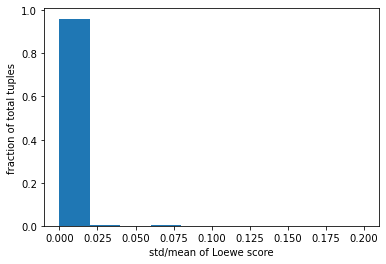

(array([9.60529704e-01, 1.56068114e-03, 1.37010291e-03, 4.65113883e-03,
       1.37525368e-03, 1.17437392e-03, 9.37438835e-04, 9.63192649e-04,
       8.13820527e-04, 8.60177392e-04]), array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ]), <BarContainer object of 10 artists>)


In [127]:
data =np.abs(list(df['std_by_mean']))
# print(data)
# print(df['Loewe_std'])
print(len(data))
plt.figure(figsize=(6, 4))
x = plt.hist(data,  weights=np.zeros_like(data) + 1. / len(data), bins=10, range=(0,0.2))
# x = plt.hist(data,range=(0,50),bins=5)
plt.xlabel('std/mean of Loewe score')
plt.ylabel('fraction of total tuples')

plt.savefig(output_dir+'/Viz/standard_deviation_Loewe_score.png')
plt.savefig(output_dir+'/Viz/standard_deviation_Loewe_score.pdf')
plt.show()
print(x)

# statistical analysis

In [92]:
#Make sure that you are preserving the datatype while reading it from file
synergy_df = pd.read_csv(training_label_synergy_score_file_path, sep='\t', \
                         dtype = {'Drug1_pubchem_cid': str ,'Drug2_pubchem_cid': str,\
                         'Cell_line':str, 'Loewe': np.float64, 'Bliss': np.float64, 'ZIP': np.float64},\
                         index_col = None)

print(synergy_df.head())
print(synergy_df.columns)

print(synergy_df['Drug1_pubchem_cid'].unique())

  Drug1_pubchem_cid Drug2_pubchem_cid Cell_line    Loewe   Bliss     ZIP
0          10026128           6918837    DIPG25 -20.3905  0.9610  0.6000
1          10027278           6918837    DIPG25 -24.6370 -8.2000 -6.2565
2          10029385           6918837    DIPG25   4.2340  3.7995  3.4965
3          10047612              2719       3D7   2.3460 -4.4470 -5.1690
4          10047612              2719       DD2   2.2820  0.5210 -3.4340
Index(['Drug1_pubchem_cid', 'Drug2_pubchem_cid', 'Cell_line', 'Loewe', 'Bliss',
       'ZIP'],
      dtype='object')
['10026128' '10027278' '10029385' ... '9966051' '9967941' '9969021']


In [93]:
#single pubchem to multiple drug_name mapping stat in drugbank
drugbank_drug_target_grouped_df = drugbank_drug_target_df.groupby('pubchem_cid')['drug_name'].unique().reset_index()
drugbank_drug_target_grouped_df['#drug_name_per_pubchem_cid'] = drugbank_drug_target_grouped_df['drug_name'].\
                                                            apply(lambda x: len(x))

drugbank_drug_target_df_multiple_drugname_per_pubchem_id =\
            drugbank_drug_target_grouped_df[drugbank_drug_target_grouped_df['#drug_name_per_pubchem_cid']>1]
print(drugbank_drug_target_df_multiple_drugname_per_pubchem_id)

     pubchem_cid                    drug_name  #drug_name_per_pubchem_cid
5221         892  [scyllo-inositol, Inositol]                           2


In [94]:
#single pubchem to multiple drug_name mapping stat: TTD
TTD_drug_target_grouped_df = TTD_drug_target_df.groupby('pubchem_cid')['drug_name'].unique().reset_index()
TTD_drug_target_grouped_df['#drug_name_per_pubchem_cid'] = TTD_drug_target_grouped_df['drug_name'].\
                                                            apply(lambda x: len(x))

TTD_drug_target_multiple_drugname_per_pubchem_id_df =\
            TTD_drug_target_grouped_df[TTD_drug_target_grouped_df['#drug_name_per_pubchem_cid']>1]
print(TTD_drug_target_multiple_drugname_per_pubchem_id_df)
print('total pubchem id with multiple drug name:', len(TTD_drug_target_multiple_drugname_per_pubchem_id_df))

      pubchem_cid                                          drug_name  \
197      10103168                                [GT-2203, VUF-5296]   
242      10127622                                [ARRY-886, AZD6244]   
930        104842                                  [LE-SN38, IT-141]   
1824     11384493                              [CAY 10471, TM-30089]   
2022     11498596                                 [TA-8995, AMG 899]   
...           ...                                                ...   
16993     9834591                           [LY404039, Pomaglumetad]   
17169     9859866  [4-methyl-2-oxo-2H-chromen-7-yl sulfamate, COU...   
17205     9865375                                  [HT-0712, OX-914]   
17406     9891761                             [AVE-5997EF, AVE-5997]   
17476     9905233                                 [CMI-977, MLN-977]   

       #drug_name_per_pubchem_cid  
197                             2  
242                             2  
930                        

In [95]:
#single drug_name to multiple pubchem mapping stat
drugbank_drug_target_grouped_df = drugbank_drug_target_df.groupby('drug_name')['pubchem_cid'].unique().reset_index()
drugbank_drug_target_grouped_df['#pubchem_cid_per_drug'] = drugbank_drug_target_grouped_df['pubchem_cid'].\
                                                            apply(lambda x: len(x))

drugbank_drug_target_df_multiple_pubchem_id_per_drugname =\
            drugbank_drug_target_grouped_df[drugbank_drug_target_grouped_df['#pubchem_cid_per_drug']>1]
print(drugbank_drug_target_df_multiple_pubchem_id_per_drugname)

Empty DataFrame
Columns: [drug_name, pubchem_cid, #pubchem_cid_per_drug]
Index: []


In [96]:
#single drug_name to multiple pubchem mapping stat
TTD_drug_target_grouped_df = TTD_drug_target_df.groupby('drug_name')['pubchem_cid'].unique().reset_index()
TTD_drug_target_grouped_df['#pubchem_cid_per_drug'] = TTD_drug_target_grouped_df['pubchem_cid'].\
                                                            apply(lambda x: len(x))

TTD_drug_target_df_multiple_pubchem_id_per_drugname =\
            TTD_drug_target_grouped_df[TTD_drug_target_grouped_df['#pubchem_cid_per_drug']>1]
print(TTD_drug_target_df_multiple_pubchem_id_per_drugname)

Empty DataFrame
Columns: [drug_name, pubchem_cid, #pubchem_cid_per_drug]
Index: []


In [97]:
#find out for how many drugcombdb drug pubchem ids we have target information
drugs_in_drugcombdb = set(drug_maccskeys_df_feature_ready['pubchem_cid'].astype(str))
drugs_having_target_info = set(drug_target_df_feature_ready['pubchem_cid'].astype(str))

print('total drugcombdb drug: ', len(drugs_in_drugcombdb))
print('target info present for: ', len(drugs_having_target_info))
print('common: ',len(drugs_in_drugcombdb.intersection(drugs_having_target_info)))

# print(drugs_in_drugcombdb, '\n')
# print(drugs_having_target_info)

common = drugs_in_drugcombdb.intersection(drugs_having_target_info)


total drugcombdb drug:  4193
target info present for:  21297
common:  1956


In [98]:
#find out for how many drugcombdb drug-pairs we have target information for both drugs
cell_lines  = synergy_df['Cell_line'].unique()
drug_pairs_per_cell_line_having_all_feature_val={x:0 for x in cell_lines}

# synergy_df = synergy_df.reset_index()


for row in synergy_df.itertuples():
        drug_pairs_per_cell_line_having_all_feature_val[row.Cell_line] += 1

print(drug_pairs_per_cell_line_having_all_feature_val) 

{'DIPG25': 1998, '3D7': 1223, 'DD2': 1219, 'HB3': 1234, 'KBM-7': 27638, 'Huh-7': 23, 'Mak': 22, 'SU-DIPG-XIII': 1032, 'TC-32': 558, 'L-1236': 1450, 'TC-71': 1013, 'U-HO1': 527, '786-0': 2341, 'A498': 2354, 'A549': 2344, 'ACHN': 2369, 'BT-549': 2316, 'CAKI-1': 2335, 'CCRF-CEM': 2306, 'COLO 205': 2339, 'DU-145': 2337, 'EKVX': 2353, 'HCC-2998': 2296, 'HCT-15': 2354, 'HCT116': 2650, 'HL-60(TB)': 2244, 'HOP-62': 2289, 'HOP-92': 2303, 'HS 578T': 2324, 'HT29': 2643, 'IGROV1': 2340, 'K-562': 2327, 'LOX IMVI': 2204, 'M14': 2329, 'MALME-3M': 2341, 'MCF7': 2347, 'MDA-MB-231': 2363, 'MDA-MB-435': 2316, 'MDA-MB-468': 2316, 'MOLT-4': 2270, 'NCI-H226': 2352, 'NCI-H322M': 2333, 'NCI-H460': 2618, 'NCI-H522': 2325, 'NCIH23': 2648, 'NCI\\\\/ADR-RES': 2370, 'OVCAR-4': 2338, 'OVCAR-5': 2368, 'OVCAR-8': 2323, 'OVCAR3': 2616, 'PC-3': 2352, 'RPMI-8226': 2236, 'RXF 393': 2302, 'SF-268': 2358, 'SF-295': 2289, 'SF-539': 2329, 'SK-MEL-2': 1646, 'SK-MEL-28': 2347, 'SK-MEL-5': 2330, 'SK-OV-3': 2655, 'SN12C': 2334, 

[3, 4, 4, 4, 4, 4, 16, 17, 18, 18, 21, 22, 23, 24, 32, 52, 74, 91, 211, 300, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 527, 541, 558, 1013, 1032, 1219, 1223, 1234, 1450, 1646, 1998, 2204, 2236, 2244, 2253, 2270, 2289, 2289, 2296, 2302, 2303, 2306, 2316, 2316, 2316, 2317, 2323, 2324, 2324, 2325, 2327, 2329, 2329, 2330, 2333, 2334, 2335, 2337, 2338, 2339, 2340, 2341, 2341, 2342, 2344, 2347, 2347, 2352, 2352, 2353, 2354, 2354, 2355, 2358, 2359, 2361, 2363, 2363, 2368, 2369, 2370, 2607, 2616, 2618, 2632, 2643, 2648, 2650, 2655, 2669, 27638]


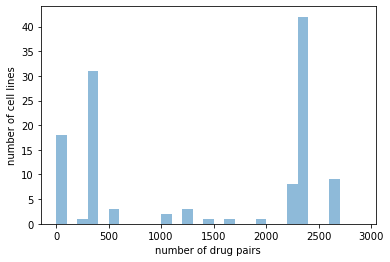

In [99]:
#plot_hist
number_of_drug_pairs_list = list((drug_pairs_per_cell_line_having_all_feature_val.values()))
number_of_drug_pairs_list.sort()
print(number_of_drug_pairs_list)

bins_seq = list(np.arange(0,3000,100))
# bins_seq = bins_seq+[20000,30000,40000,50000]

# print(bins_seq)

fig, ax = plt.subplots()
ax.hist(drug_pairs_per_cell_line_having_all_feature_val.values(),bins=bins_seq,alpha=0.5,label='#total drug pairs')
# y_label = 'number of cell lines (' + str(len(number_of_drug_pairs_list)) + ')'
y_label = 'number of cell lines'
x_label = 'number of drug pairs'

ax.set_ylabel(y_label)
ax.set_xlabel(x_label)
# ax.legend()

# plt.title('#drug combinations per cell line for which all feature values are available')
# file_name = output_dir+'/Viz/'+ 'drug_pairs_per_cell_line.pdf'
# os.makedirs(os.path.dirname(file_name), exist_ok=True)
# plt.savefig(file_name, format= 'pdf', bbox_inches = 'tight' )
plt.show()



In [100]:
count =0
for x in number_of_drug_pairs_list:
    if x>2000:
        count+=1
print (count)

60
